In [8]:
import sys
sys.path.append("..")

import numpy as np
from propagation_simulator.environment import environment
from classes.nfpo import NFPO
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

## 環境設定

In [9]:
frequency = 920.4e6
c = 2.998e8
wave_length = c/frequency
sample_count = 100

## 位相サンプル生成

In [10]:
tag_location= [2,3]
k=-2
antennas_population = 4
antennas_space = 0.1

In [11]:
x_list = np.arange(-2,2.1,0.5)
y_list = np.arange(1.0,4.1,0.5)
solve_time_matrix = np.zeros(shape=(x_list.shape[0], y_list.shape[0]))
error_matrix = np.zeros(shape=(x_list.shape[0], y_list.shape[0]))

In [ ]:
for i, x in enumerate(x_list):
    for j, y in enumerate(y_list):
        tag_location = np.array([x,y])
        print("tag_location = " + str(tag_location))
        env = environment(
            antennas_space=antennas_space,
            antennas_population=antennas_population,
            tag=tag_location,
            frequency=frequency,
            k=k,
            sample_count=sample_count,
        )
        _, phases, phases_with_noise = env.get_phases()

        solve_time = 0
        error = 0
        best_initial_value=np.array([0,2])
        min_obj = 1e10
        for grid_x in np.arange(-2,2.0,1.0)+0.5:
            for grid_y in np.arange(1.0,4.0,1.0)+0.5:
                initial_value = np.array([grid_x, grid_y])
                nfpo = NFPO(
                    sample_count=sample_count,
                    antennas_space=antennas_space,
                    phases=phases,
                    antennas_population=antennas_population,
                    wave_length = wave_length,
                    tag_location = tag_location,
                    initial_value = initial_value,
                    range_center = [0,2.5],
                    y_err_range = 1.5,
                    x_err_range = 2,
                    k=k,
                    is_noise_included=True,
                )
                result = nfpo.solve(tee=False, time_limit=180)
                solve_time = solve_time + result["solving_time"]
                print(f"    initial_value = {initial_value}")
                print(f"        obj_value = {result["values"]["obj"]}")
                print(f"        solve_time = {result["solving_time"]}")
                if min_obj > result["values"]["obj"]:
                    min_obj = result["values"]["obj"]
                    error = result["values"]["error"]
                    value = np.array([result["values"]["x"], result["values"]["y"]])
        print(f"    value = {best_initial_value}, error = {error}, solve_time = {solve_time}")
        # nfpo = NFPO(
        #     sample_count=sample_count,
        #     antennas_space=antennas_space,
        #     phases=phases,
        #     antennas_population=antennas_population,
        #     wave_length = wave_length,
        #     tag_location = tag_location,
        #     initial_value = best_initial_value,
        #     y_err_range = 0.2,
        #     x_err_range = 0.2,
        #     k=k,
        #     is_noise_included=True,
        # )
        # result = nfpo.solve(tee=False, time_limit=10)
        # solve_time = solve_time + result["solving_time"]
        error_matrix[i][j] = error
        solve_time_matrix[i][j] = solve_time
        print("    error = " + str(error) + "[m], solve time = " + str(solve_time) + "[s]")

tag_location = [-2.  1.]


In [6]:
np.save("../data/simulation/accuracy_multi_start.npy", error_matrix)
np.save("../data/simulation/solve_time_multi_start.npy", solve_time_matrix)

320.9804761904763
0.13385996804331138


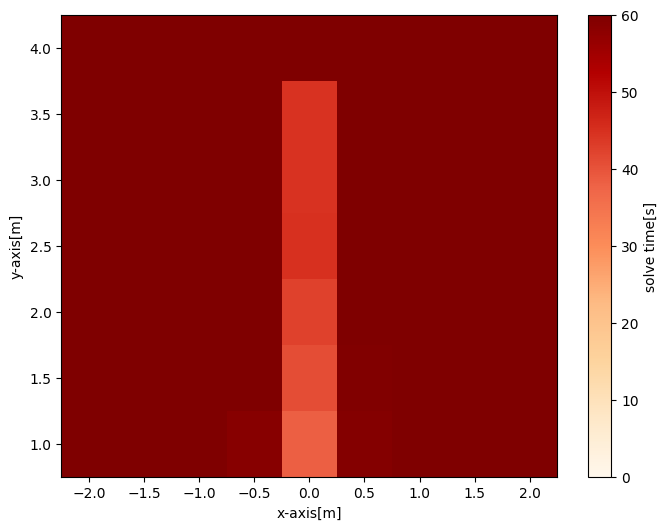

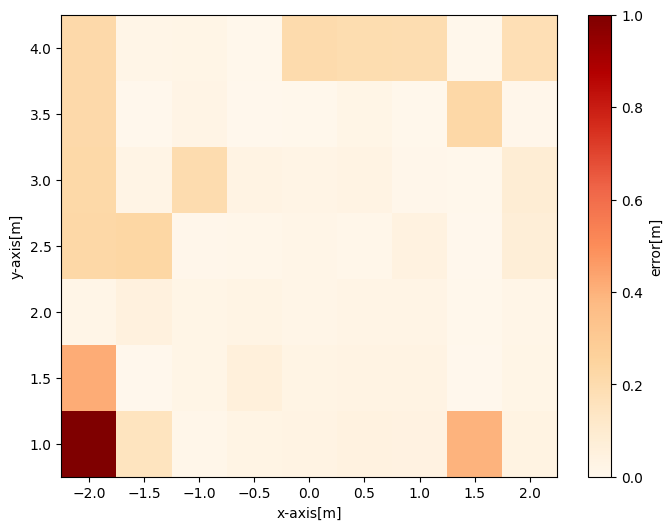

In [ ]:
Y_list, X_list = np.meshgrid(y_list, x_list)
norms = [
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=60)
]

print(solve_time_matrix.mean())
print(error_matrix.mean())

fig, axes = plt.subplots(figsize=(8,6))
mappable = axes.pcolormesh(X_list, Y_list, solve_time_matrix, cmap='OrRd', norm=norms[1])
axes.set_xlabel("x-axis[m]")
axes.set_ylabel("y-axis[m]")
cb=fig.colorbar(mappable, ax=axes)
cb.set_label("solve time[s]")

fig, axes = plt.subplots(figsize=(8,6))
mappable = axes.pcolormesh(X_list, Y_list, error_matrix, cmap='OrRd', norm=norms[0])
axes.set_xlabel("x-axis[m]")
axes.set_ylabel("y-axis[m]")
cb=fig.colorbar(mappable, ax=axes)
cb.set_label("error[m]")